#About the data
Here we got a 58k dataframe with complaints of citizens of Saint Petersburg,   Russia to the local authorities about some problems in their neighbourhoods  
Data columns: id, petition text, reason category

In [ ]:
!wget "https://drive.google.com/uc?id=1Z0DjhOQGTd7knmUeq_0zxc_frDpp5s_z&export=download" -O Petitions.csv

--2023-10-21 15:41:33--  https://drive.google.com/uc?id=1Z0DjhOQGTd7knmUeq_0zxc_frDpp5s_z&export=download
Resolving drive.google.com (drive.google.com)... 142.251.16.113, 142.251.16.138, 142.251.16.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.16.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pf4a62afntateevf3b3hr8dkcolddjfn/1697902875000/11333756286927175769/*/1Z0DjhOQGTd7knmUeq_0zxc_frDpp5s_z?e=download&uuid=9302688b-1738-4019-b8cb-d2856bec6ed7 [following]
--2023-10-21 15:41:36--  https://doc-0c-24-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pf4a62afntateevf3b3hr8dkcolddjfn/1697902875000/11333756286927175769/*/1Z0DjhOQGTd7knmUeq_0zxc_frDpp5s_z?e=download&uuid=9302688b-1738-4019-b8cb-d2856bec6ed7
Resolving doc-0c-24-docs.googleusercontent.com (doc-0c-24-docs.googleusercontent.com)... 172.253.115.132, 2607

# Preprocessing

In [ ]:
import numpy as np
import pandas as pd

! pip install pymorphy3
from pymorphy3 import MorphAnalyzer

! pip install razdel
from razdel import tokenize

import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('russian')
stopwords += ['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'э', 'ю', 'я', 'ъ', 'ь', 'ы']



from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 65.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
class preprocessing:

  def __init__(self):
    pass

  def cleaning(self):
    self.object_text = re.sub('[^\s^\w]+', ' ', re.sub('[\r\n]+', ' ', re.sub('[\d,a-zA-Z]', ' ',self.object_text)))

  def tokenize(self):
    tokens = list(tokenize(self.object_text))
    self.object_text = [i.text for i in tokens]


  def lemmatization(self):
    morph = MorphAnalyzer()
    self.object_text = [morph.normal_forms(w)[0] for w in self.object_text]

  def stopws(self):
    self.object_text = [w for w in self.object_text if w not in self.stopwords]

  def glue(self):
    text = ''
    for i in self.object_text:
      text += ' ' + i
    self.object_text = text[1:-1]

  def exec(self, object_text, stopwords):
    self.object_text = object_text
    self.stopwords = stopwords
    self.cleaning()
    self.tokenize()
    self.lemmatization()
    self.stopws()

    return self.object_text

In [ ]:
data = pd.read_csv("Petitions.csv")
data = data[:2500]

In [ ]:
b = preprocessing()
data['petition'] = [b.exec(data.iloc[i, 1], stopwords) for i in range(len(data))]

In [ ]:
vocab = {}
tokenized = []

for i in range(len(data['petition'])):
  for j in data['petition'][i]:
    tokenized.append(j)

for i  in range(len(tokenized)):
  if tokenized[i] not in vocab.values():
    vocab[tokenized[i]] = i

counter = 1
for key in vocab.keys():
  vocab[key] = counter
  counter += 1


print("Words in vocab: ", len(vocab) )
print("Words in text: ", len(tokenized))

Words in vocab:  3857
Words in text:  23821


# Vectorizing
Here I will use [Natasha/navec](github.com/natasha/navec 'github.com') pre-trained embeddings of russsian words

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec
from navec import Navec
path = '/content/navec_hudlit_v1_12B_500K_300d_100q.tar'

--2023-10-21 15:47:51--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  20.6MB/s    in 2.5s    

2023-10-21 15:47:54 (20.6 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
navec = Navec.load(path)

In [ ]:
main_arr = []

unk, kn = 0, 0
for i in data['petition']:

  arr = []
  for j in i:
    if not(j in navec):
      unk+=1
      arr.append(navec['<unk>'])
    else:
      kn+=1
      arr.append(navec[j])
  main_arr.append(arr)


print("Unknown words: ", unk, " /// ", round(unk/len(tokenized)*100, 2),'%')
print("Known words: ", kn, " /// ", round(kn/len(tokenized)*100, 2),'%')

Unknown words:  904  ///  3.79 %
Known words:  22917  ///  96.21 %


In [ ]:
maxwords = len(max(main_arr, key = len))
for i in main_arr:
  a = len(i)
  for j in range(maxwords - len(i)):
    i.append(navec['<pad>'])
  take = i[0:a]
  replace = i[maxwords - a:maxwords]
  i[maxwords - a:maxwords] = take
  i[0:a] = replace

# Getting labels

In [ ]:
encoder = LabelEncoder()
data['reason_category'] = encoder.fit_transform(data['reason_category'])
encoding_data = encoder.inverse_transform(sorted(data['reason_category'].unique()))

In [ ]:
encoding_data

array(['Благоустройство', 'Водоотведение', 'Водоснабжение', 'Кровля',
       'Нарушение порядка пользования общим имуществом',
       'Нарушение правил пользования общим имуществом',
       'Незаконная информационная и (или) рекламная конструкция',
       'Незаконная реализация товаров с торгового оборудования (прилавок, ящик, с земли)',
       'Повреждения или неисправность элементов уличной инфраструктуры',
       'Подвалы', 'Санитарное состояние', 'Содержание МКД',
       'Состояние рекламных или информационных конструкций', 'Фасад',
       'Центральное отопление'], dtype=object)

In [ ]:
X = torch.tensor(np.array(main_arr))

cats = data['reason_category'].values
classes_dict = {}
cat_unique = np.unique(cats)
cat_unique_size = len(cat_unique)
for i in range(len(cat_unique)):
    classes_dict[cat_unique[i]] = i

cats_size = len(cats)
cats1 = []

for i in range(cats_size):
    v = np.zeros(cat_unique_size)
    v[classes_dict[cats[i]]] += 1
    cats1.append(v)
cats1 = np.array(cats1)

y = torch.tensor(cats1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2125, 179, 300]),
 torch.Size([375, 179, 300]),
 torch.Size([2125, 15]),
 torch.Size([375, 15]))

# Creating test and train datasets via torch

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.labels = y
        self.data = X
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, label

In [ ]:
ds_train = CustomDataset(X_train, y_train)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size = 256, shuffle = True, drop_last=True)

# Defining RNN and training it

In [ ]:
num_classes = y.shape[1]
input_size = 300
num_layers = 1
hidden_size = 128
batch_size = 256
num_epochs = 18
learning_rate = 0.001

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input):
        h0 = torch.zeros(self.num_layers, len(input), self.hidden_size)

        out, h = self.rnn(input, h0)
        out = h
        out = self.fc(out[0])
        return out


In [ ]:
rnn = RNN(input_size, hidden_size, num_classes, num_layers)
lf = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr = learning_rate)

In [ ]:
story_rnn=[]
for epoch in range(num_epochs):
  for context, label in dl_train:

    scores = rnn(context)
    loss = lf(scores, label)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  story_rnn.append(loss.item())
  print("epoch: {}, Loss: {}".format(epoch, loss.item()))

epoch: 0, Loss: 1.7771976792719215
epoch: 1, Loss: 1.338886527926661
epoch: 2, Loss: 1.1562937842099927
epoch: 3, Loss: 1.1082818795694038
epoch: 4, Loss: 0.9934234274842311
epoch: 5, Loss: 0.9019714353053132
epoch: 6, Loss: 0.8998836271639448
epoch: 7, Loss: 0.747237590039731
epoch: 8, Loss: 0.7156985778274247
epoch: 9, Loss: 0.6904576890447061
epoch: 10, Loss: 0.6736926750018029
epoch: 11, Loss: 0.739181361233932
epoch: 12, Loss: 0.6385416262382932
epoch: 13, Loss: 0.5902535459026694
epoch: 14, Loss: 0.5854902407081681
epoch: 15, Loss: 0.4788860382795974
epoch: 16, Loss: 1.4900416827549634
epoch: 17, Loss: 0.621624315441295


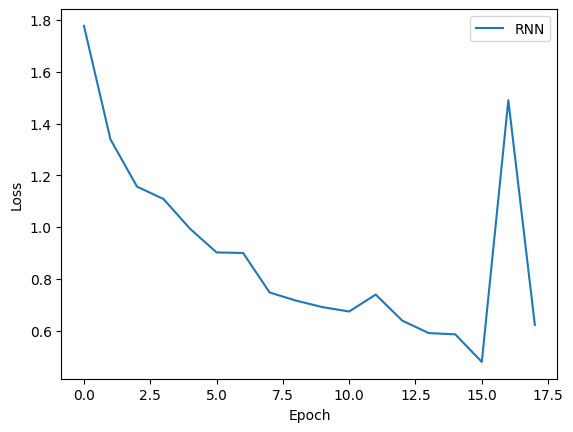

In [ ]:
import matplotlib.pyplot as plt
plt.plot(story_rnn, label='RNN')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend ()
plt.show()

In [ ]:
y_pred_test = nn.Softmax(dim=1)(rnn(torch.tensor(X_test)).detach())
y_pred_train = nn.Softmax(dim=1)(rnn(torch.tensor(X_train)).detach())

y_test_mas = [i.argmax() for i in y_test]
y_pred_mas_test = [i.argmax() for i in y_pred_test.numpy()]

y_train_mas = [i.argmax() for i in y_train]
y_pred_mas_train = [i.argmax() for i in y_pred_train.numpy()]

In [ ]:
print("Accuracy on test: ", accuracy_score(y_test_mas, y_pred_mas_test))
print("Accuracy on train: ", accuracy_score(y_train_mas, y_pred_mas_train))

Accuracy on test:  0.7733333333333333
Accuracy on train:  0.796235294117647


# Defining GRU and training it

In [ ]:
num_classes = y.shape[1]
input_size = 300
num_layers = 1
hidden_size = 128
batch_size = 256
num_epochs = 18
learning_rate = 0.001

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input):
        h0 = torch.zeros(self.num_layers, len(input), self.hidden_size)

        out, h = self.gru(input, h0)
        out = out[:, -1, :]
        out = self.fc(out)

        return out


In [ ]:
gru = GRU(input_size, hidden_size, num_classes, num_layers)
lf = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru.parameters(), lr = learning_rate)

In [ ]:
story_gru=[]
for epoch in range(num_epochs):
  for context, label in dl_train:

    scores = gru(context)
    loss = lf(scores, label)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  story_gru.append(loss.item())
  print("epoch: {}, Loss: {}".format(epoch, loss.item()))

epoch: 0, Loss: 2.121636137366295
epoch: 1, Loss: 1.2739908776711673
epoch: 2, Loss: 1.3060528465139214
epoch: 3, Loss: 1.1375739220820833
epoch: 4, Loss: 1.0189023242346593
epoch: 5, Loss: 0.8630415075022029
epoch: 6, Loss: 0.8334166608910891
epoch: 7, Loss: 0.8686152417794801
epoch: 8, Loss: 0.7245641289118794
epoch: 9, Loss: 0.6415353570300795
epoch: 10, Loss: 0.6921584710835305
epoch: 11, Loss: 0.6181226186126878
epoch: 12, Loss: 0.5324938228714018
epoch: 13, Loss: 0.5943338732013217
epoch: 14, Loss: 0.5285757149704295
epoch: 15, Loss: 0.4065969434868748
epoch: 16, Loss: 0.4304856212929735
epoch: 17, Loss: 0.3924550894598724


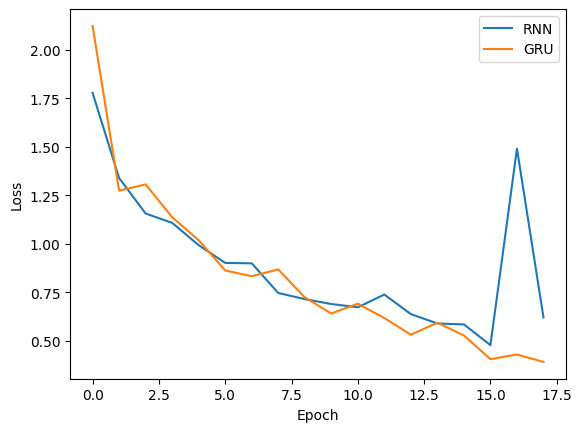

In [ ]:
plt.plot(story_rnn, label='RNN')
plt.plot(story_gru, label='GRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend ()
plt.show()

In [ ]:
y_pred_test = nn.Softmax(dim=1)(gru(torch.tensor(X_test)).detach())
y_pred_train = nn.Softmax(dim=1)(gru(torch.tensor(X_train)).detach())

y_test_mas = [i.argmax() for i in y_test]
y_pred_mas_test = [i.argmax() for i in y_pred_test.numpy()]

y_train_mas = [i.argmax() for i in y_train]
y_pred_mas_train = [i.argmax() for i in y_pred_train.numpy()]


In [ ]:
print("Accuracy on test: ", accuracy_score(y_test_mas, y_pred_mas_test))
print("Accuracy on train: ", accuracy_score(y_train_mas, y_pred_mas_train))

Accuracy on test:  0.848
Accuracy on train:  0.888


# Defining LSTM and training it

In [ ]:
num_classes = y.shape[1]
input_size = 300
num_layers = 1
hidden_size = 128
batch_size = 256
num_epochs = 18
learning_rate = 0.001

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input):
        h0 = torch.zeros(self.num_layers, len(input), self.hidden_size)
        c0 = torch.zeros(self.num_layers, len(input), self.hidden_size)
        out, _ = self.lstm(input, (h0, c0))

        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
lstm = LSTM(input_size, hidden_size, num_classes, num_layers)
lf = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr = learning_rate)

In [ ]:
story_lstm=[]
for epoch in range(num_epochs):
  for context, label in dl_train:

    scores = lstm(context)
    loss = lf(scores, label)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
  story_lstm.append(loss.item())
  print("epoch: {}, Loss: {}".format(epoch, loss.item()))

epoch: 0, Loss: 2.2983787204138935
epoch: 1, Loss: 1.3936517885886133
epoch: 2, Loss: 1.137897893146146
epoch: 3, Loss: 1.09391051120474
epoch: 4, Loss: 0.9647282307269052
epoch: 5, Loss: 0.8555126350838691
epoch: 6, Loss: 0.8099299540699576
epoch: 7, Loss: 0.8214021890671575
epoch: 8, Loss: 0.7804929096382693
epoch: 9, Loss: 0.6411990343767684
epoch: 10, Loss: 0.5870504107115266
epoch: 11, Loss: 0.586453476393217
epoch: 12, Loss: 0.6875713070658094
epoch: 13, Loss: 0.6022109386212833
epoch: 14, Loss: 0.5881008790875057
epoch: 15, Loss: 0.5552507326774503
epoch: 16, Loss: 0.4757801994910551
epoch: 17, Loss: 0.3777434129115136


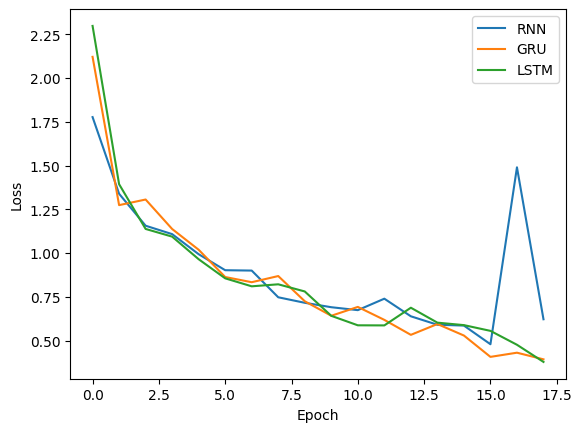

In [ ]:
plt.plot(story_rnn, label='RNN')
plt.plot(story_gru, label='GRU')
plt.plot(story_lstm, label='LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend ()
plt.show()

In [ ]:
y_pred_test = nn.Softmax(dim=1)(lstm(torch.tensor(X_test)).detach())
y_pred_train = nn.Softmax(dim=1)(lstm(torch.tensor(X_train)).detach())

y_test_mas = [i.argmax() for i in y_test]
y_pred_mas_test = [i.argmax() for i in y_pred_test.numpy()]

y_train_mas = [i.argmax() for i in y_train]
y_pred_mas_train = [i.argmax() for i in y_pred_train.numpy()]

In [ ]:
print("Accuracy on test: ", accuracy_score(y_test_mas, y_pred_mas_test))
print("Accuracy on train: ", accuracy_score(y_train_mas, y_pred_mas_train))

Accuracy on test:  0.8266666666666667
Accuracy on train:  0.88
